# Heston model: Monte Carlo pricing

In this notebook, we show how to price European options with the Heston stochastic volatility model and a Monte Carlo procedure.

The Heston model is defined by the following system of stochastic differential equations where the stock price follows a geometric Brownian motion and its variance follows a Cox-Ingersoll-Ross (CIR) process,

\begin{align}
	&dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_t^{(1)} \\
	&dv_t = \kappa ( \theta - v_t ) dt + \sigma \sqrt{v_t} dW_t^{(2)} \\
	&dW_t^{(1)} dW_t^{(2)} = \rho dt
\end{align}

where $S_t$ is the underlying stock price, $v_t$ is its variance, $\mu$ is the expected return, $\kappa$ is the mean-reversion rate, $\theta$ is the long-term variance, $\sigma$ is the volatility of volatility, $W_t$ is a Wiener process and $\rho$ is the correlation coefficient between the Brownian motions. There are also two initial parameters, $S_0$ and $v_0$ which are non-negative.

The process $v_t$ is strictly positive if the Feller condition is satisfied. It is given by

\begin{equation}
    2 \kappa \theta > \sigma^2.
\end{equation}

The Monte Carlo procedure for the Heston model is similar to that of the Black-Scholes model. The key difference is that we need to simulate the variance paths. The variance values are then used to generate the stock price paths. Also, we need to generate correlated standard normal random variables. Additionally, it is necessary to generate the full paths whereas we can directly simulate the stock price at maturity with Black-Scholes. 

Let's define some parameters and implement the Monte Carlo procedure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1           # maturity
S0 = 55         # spot price
K = 50          # strike price
r = 0.04        # risk-free interest rate
q = 0.02        # dividend rate
v0 = 0.04       # initial variance
rho = -0.7      # correlation between Brownian motions
kappa = 2       # mean reversion rate
theta = 0.04    # Long term mean of variance
sigma = 0.3     # volatility of volatility
n_steps = 252   # number of time steps
n_paths = 5000  # number of paths
n_blocks = 2000 # number of blocks
dt = T/n_steps  # time step

# Initialize arrays
Vc_list = np.zeros(n_blocks) # call array
Vp_list = np.zeros(n_blocks) # put array

for j in range(n_blocks):
    # Correlated normal random variables
    W1, W2 = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], (n_steps, n_paths)).T
    
    # Initialize array for variance
    v = np.zeros((n_steps + 1, n_paths)).T
    v[:, 0] = v0
    
    # Initialize array for stock
    S = np.zeros((n_steps + 1, n_paths)).T
    S[:, 0] = S0
    
    # Compute the paths
    for i in range(1, n_steps + 1):
        S[:, i] = S[:, i-1] * np.exp((r - q - 0.5*v[:, i-1])*dt \
                                     + np.sqrt(v[:, i-1])*np.sqrt(dt)*W2[:, i-1])
        v[:, i] = np.abs(v[:, i-1] + kappa*(theta - v[:, i-1])*dt \
                         + sigma*np.sqrt(v[:, i-1])*np.sqrt(dt)*W1[:, i-1])
    
    # Compute the discounted option price for the block    
    Vc_list[j] = np.exp(-r*T)*np.mean(np.maximum(S[:,-1] - K, 0))
    Vp_list[j] = np.exp(-r*T)*np.mean(np.maximum(K - S[:,-1], 0))

# Final option price (mean of the prices from each block)
Vc = np.mean(Vc_list)
Vp = np.mean(Vp_list)

print('Call price: ' + str(round(Vc, 5)))
print('Put price:  ' + str(round(Vp, 5)))

Call price: 7.78456
Put price:  1.91485


Let's visualize some price paths generated by the procedure.

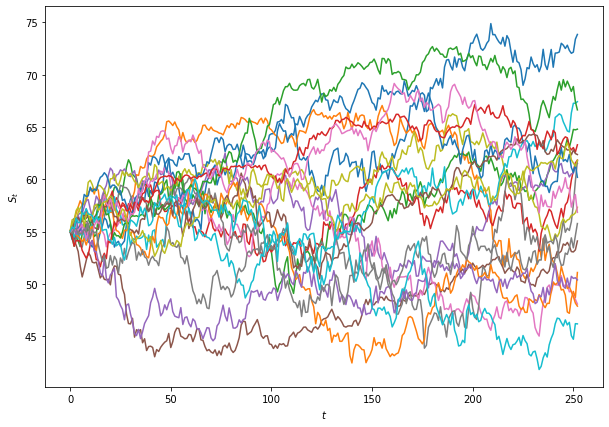

In [2]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
for i in range(20):
    ax.plot(S[i, :])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S_t$');

Let's also visualize some variance paths.

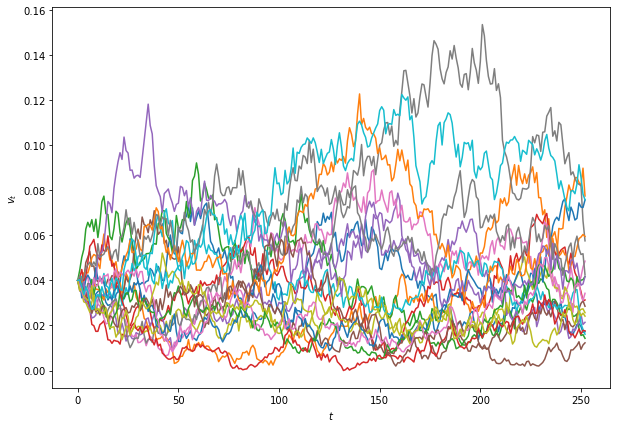

In [3]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
for i in range(20):
    ax.plot(v[i, :])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_t$');

Let's plot the distribution of the stock price at maturity (only prices from the last block).

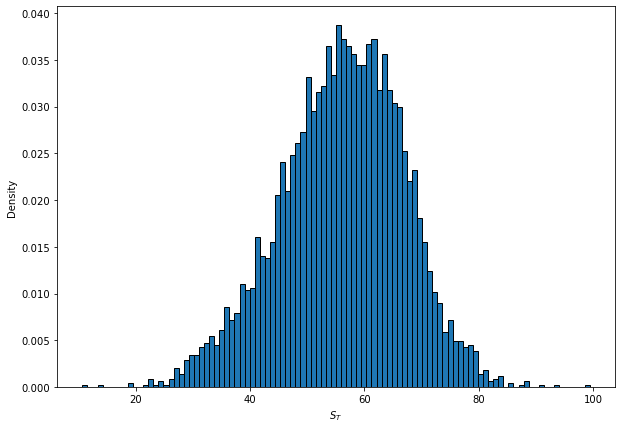

In [4]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.hist(S[:,-1], 100, density=True, ec='k')
ax.set_ylabel('Density')
ax.set_xlabel(r'$S_T$');

Let's plot the distribution of the variance at maturity (only variances from the last block).

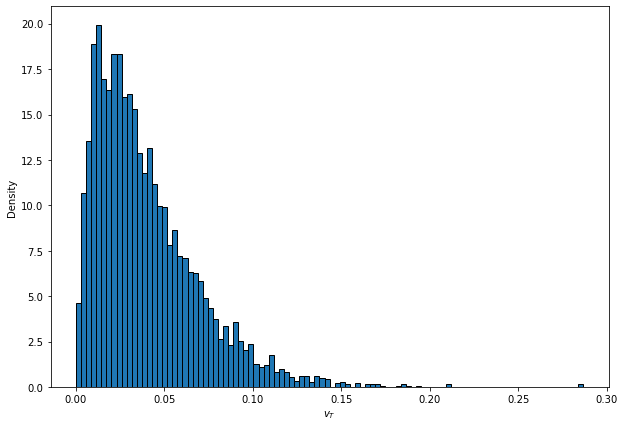

In [5]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.hist(v[:,-1], 100, density=True, ec='k')
ax.set_ylabel('Density')
ax.set_xlabel(r'$v_T$');